# Generate the Distance Matrices
For each name in the stock watchers data, we will compute the distance to each name in the propublica data (subsetted to House/Senate). First we will clean up the names a bit.

In [21]:
import os
from dotenv import load_dotenv
import sys
import pandas as pd
import jellyfish
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from importlib import reload

sys.path.append("../")

from resources.bitio_helper import download_dataset
import resources.bitformat
reload(resources.bitformat)
from resources.bitformat import format_bitdotio


load_dotenv()
PG_STRING = os.getenv("BITIO_PG_STRING")
USERNAME = os.getenv("BITIO_USERNAME")

BLUE = "#0059ff"
GOLD = "#fdbd28"
GREEN = "#28D9AA"
RED = "#EE5149"
METAL_SUN = "#AD8D40"
DARK_ORCHID = "#9A34D1"
MAGENTA = "#8A4859"
OXFORD = "#121C3B"
PINK = "#DB9995"
GREY = "#788995"

## Data Download and Preprocessing

In [2]:
# Download from bit.io
propublica_data = download_dataset('"bitdotio/congress-names"."propublica_names"', PG_STRING)
stockwatchers_data = download_dataset('"bitdotio/congress-names"."stock_watchers_names"', PG_STRING)

In [76]:
# some basic cleaning
## remove missing name components from propub data
propublica_data["name_clean"] = propublica_data["name"].str.replace(" nothing", "")

## remove honorifics, titles, etc. from SW data
replacements = '|'.join(['^Mr. ', '^Mrs. ', '^Hon. ', '^None ', ' Honorable', 'Hon ',
                         'Facs ', ' MD,'])
stockwatchers_data["name_clean"] = stockwatchers_data["name"].str.replace(replacements, "", regex=True)

In [77]:
prp_house = propublica_data.loc[propublica_data.chamber == "house", ["name_clean"]].rename(columns={"name_clean":"name"})
sw_house = stockwatchers_data.loc[stockwatchers_data.chamber == "house", ["name_clean"]].rename(columns={"name_clean":"name"})

prp_senate = propublica_data.loc[propublica_data.chamber == "senate", ["name_clean"]].rename(columns={"name_clean":"name"})
sw_senate = stockwatchers_data.loc[stockwatchers_data.chamber == "senate", ["name_clean"]].rename(columns={"name_clean":"name"})


In [78]:
prp_names_house = list(prp_house["name"])
prp_names_senate = list(prp_senate["name"])

## Calculate Levenshtein Distances

In [79]:
# helper function for getting levenshtein distance across columns
def normalized_ld(name, candidate):
    ld = jellyfish.levenshtein_distance(name, candidate)
    maxlength = max([len(name), len(candidate)])
    normalized_ld = 1-(ld/maxlength)
    return normalized_ld

def ls(name, candidates):
    """Calculate the normalized levenshtein distance between a name
    and a list of candidate names"""
    return list(map(lambda x: normalized_ld(name, x), candidates))

def make_ls_matrix(names, candidates):
    """Given a dataframe of names and a list of candidates, return a
    dataframe with names as rows and candidates as columns with
    scores as values, along with columns for best match and best
    match score"""
    normalized_lds = names.apply(lambda x: ls(x["name"], candidates), axis=1, result_type="expand")
    normalized_lds.columns = candidates
    normalized_lds.insert(loc=0, column = "stock_watchers_name", value=names["name"])
    normalized_lds.insert(loc=1, column="closest_match", value=normalized_lds.iloc[:,1:].idxmax(axis=1))
    normalized_lds.insert(loc=2, column="closest_match_score", value=normalized_lds.iloc[:,2:].max(axis=1))

    return normalized_lds.sort_values("closest_match_score", axis=0)


In [80]:
house_mat = make_ls_matrix(names=sw_house, candidates=prp_names_house)
senate_mat = make_ls_matrix(names = sw_senate, candidates=prp_names_senate)

### Get Top Matches for Visualization

In [81]:
def top_n_matches(member, n=5):
    """Takes a row for the matching matrix generated above. Returns a new
    matrix with the top N members and their scores."""
    top_matches = list(member[3:].rank().sort_values().index.values[-n:])
    match_sub = member.loc[top_matches]
    return match_sub


In [82]:
list(top_n_matches(senate_mat.iloc[1], 7).index.values)

prp_senate_sub = ['Mitch McConnell', 'Michael Bennet', 'Shelley Moore Capito',
                  'Richard M. Burr', 'John Hickenlooper']
sw_senate_sub = ['A. Mitchell Mcconnell, Jr.', 'Michael F Bennet', 'Shelley M Capito',
                 'Richard M Burr', 'John W Hickenlooper']

In [97]:
list(top_n_matches(house_mat.iloc[10], 5).index.values)

['Jeffrey Duncan',
 'Marilyn Strickland',
 'Beth Van Duyne',
 'Neal Dunn',
 'Sean Patrick Maloney']

['blue', 'blue', 'blue', 'blue', 'blue', 'blue']

/var/folders/vq/mfrl6bsd37jglvmz0vyxf3000000gn/T/ipykernel_1994/2969680242.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(x, minor=False)


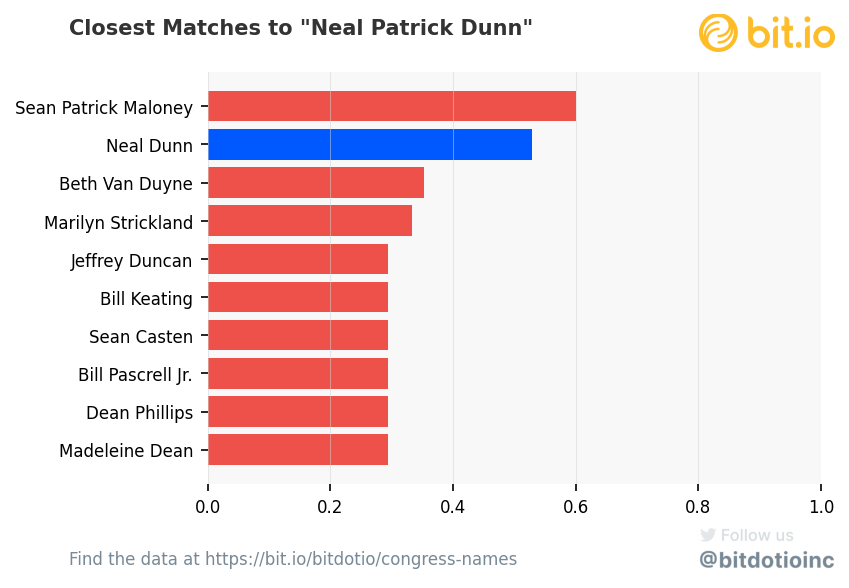

In [119]:
dunn_matches = top_n_matches(house_mat.iloc[10], 10)
x = list(dunn_matches.index.values)

plt.style.use("../resources/bitdotio.mplstyle")
fig, ax = plt.subplots(1,1,figsize=(6,4), dpi=150)

ax.barh(x, dunn_matches, color=[RED]*8 + [BLUE, RED] )
ax.set_yticklabels(x, minor=False)
ax.set_xlim(0,1)

# add vertical grid
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

format_bitdotio(fig, title='Closest Matches to "Neal Patrick Dunn"', text="Find the data at https://bit.io/bitdotio/congress-names",
                title_fontsize=10, logowidths=0.15)

if not os.path.exists("../figures"):
    os.makedirs("../figures")
plt.savefig("../figures/dunn.png", dpi=300)

plt.show()


In [83]:
house_mat.to_clipboard()

In [84]:
senate_sub = (senate_mat.loc[senate_mat["stock_watchers_name"].isin(sw_senate_sub), ["stock_watchers_name"]+prp_senate_sub]
                .set_index("stock_watchers_name"))
senate_sub = senate_sub.iloc[:, [0,2,1,4,3]]
senate_sub

,Mitch McConnell,Shelley Moore Capito,Michael Bennet,John Hickenlooper,Richard M. Burr
stock_watchers_name,,,,,
"A. Mitchell Mcconnell, Jr.",0.538462,0.230769,0.346154,0.230769,0.230769
Shelley M Capito,0.125000,0.800000,0.187500,0.058824,0.125000
Michael F Bennet,0.375000,0.200000,0.875000,0.117647,0.375000
John W Hickenlooper,0.157895,0.100000,0.210526,0.894737,0.105263
Richard M Burr,0.200000,0.150000,0.357143,0.058824,0.933333


In [85]:
import matplotlib.colors as clr
cmap = clr.LinearSegmentedColormap.from_list('RedGrnGld', ['white', GOLD, BLUE], N=256)


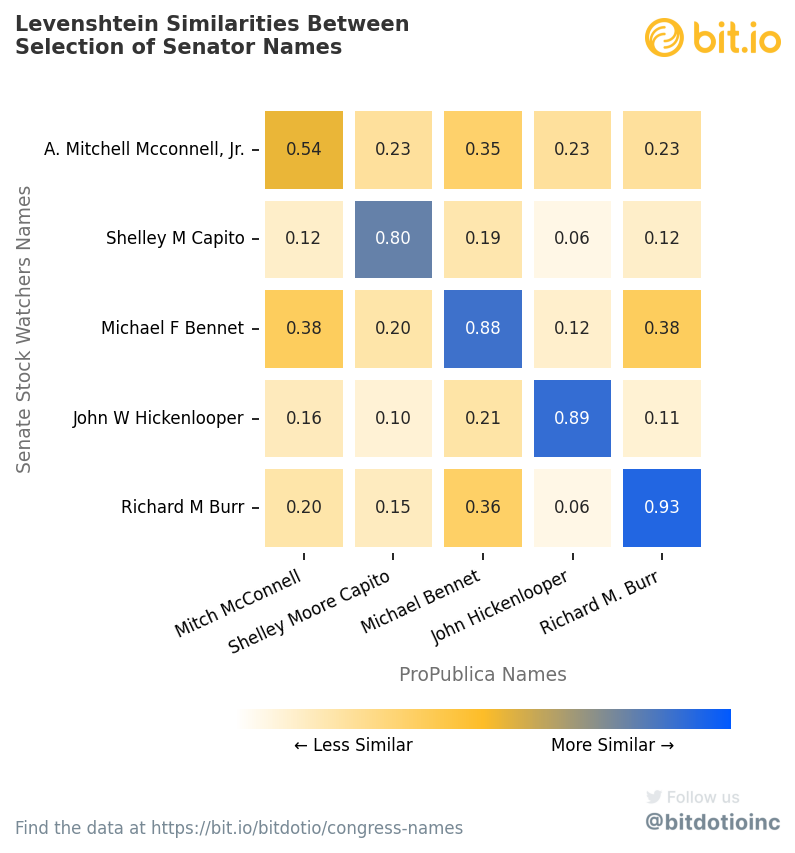

In [25]:
plt.style.use("../resources/bitdotio.mplstyle")

fig, ax = plt.subplots(figsize=(6,6), dpi=150)
sns.heatmap(senate_sub, vmin=0, vmax=1, annot=True, fmt=".2f", ax=ax,
            linewidths=5, linecolor="white", cbar=False, cmap=cmap,
            square=True)

# rotate labels
ax.set_xticklabels(senate_sub.columns, rotation=25, ha="right")
#ax.set_yticklabels(senate_sub.index, rotation=-25, va="bottom")

# colorbar
cbar = ax.figure.colorbar(ax.collections[0], ax=ax, ticks=None, orientation='horizontal',
                          fraction=0.15, pad=0.22, aspect=25, shrink=0.6)
cbar.ax.zorder = -10
cbar.outline.set_visible(False)
cbar.set_ticks([])

height = 7.15
hadjust = 0.8
ax.text(4.75 - hadjust, height, "More Similar →", ha="center", va="center", fontsize=8, rotation=0, zorder=10,
        color="black", fontdict={"fontweight":"normal"})
ax.text(0.25 + hadjust, height, "← Less Similar", ha="center", va="center", fontsize=8, rotation=0, zorder=10,
        color="black", fontdict={"fontweight":"normal"}) 

# labels
ax.set_ylabel("Senate Stock Watchers Names", fontsize=9)
ax.set_xlabel("ProPublica Names", fontsize=9)

# apply bit.io formatting
format_bitdotio(fig, title="Levenshtein Similarities Between\nSelection of Senator Names", rect=[0.02,0.05,1.1,0.88],
                text = "Find the data at https://bit.io/bitdotio/congress-names",
                title_fontsize=10, logowidths=0.15)

if not os.path.exists("../figures"):
    os.makedirs("../figures")
plt.savefig("../figures/senate_matrix.png", dpi=300)

plt.show()
